In [310]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    plt.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):


    centroids = pd[np.random.choice(pd.shape[0], K)]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
    return C, centroids

def add_top_n_expressed_label_to_var(data,top_n):
    cutoff = sorted(data.var.n_counts, reverse=True)[top_n]

    for i in range(0, data.var.shape[0]):
        if data.var.iloc[i,:].n_counts > cutoff:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = True
        else:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = False
    


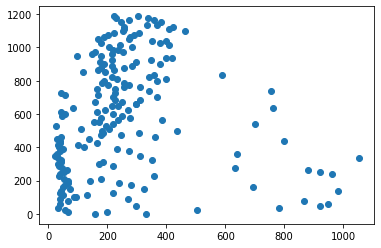

In [311]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")

plot_one_row_scatter(s745_df, 1,s745_time )


In [313]:

s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1000)


add_top_n_expressed_label_to_var(s814_adata,1)
print(s814_adata.var)


#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
#s814_pd = get_periodgram(s814_adata[:,s814_adata.var.highly_variable]) 
s814_pd = get_periodgram(s814_adata) 
s814_pd_array = np.array([i[1] for i in s814_pd])

                                                       n_counts  \
hsa-miR-10a-5p                                      1114.059082   
hsa-miR-26a-5p                                      1027.287598   
hsa-miR-302a-3p,hsa-miR-302b-3p,hsa-miR-302c-3p...  1087.101562   
hsa-miR-335-3p                                      1019.931946   
hsa-miR-363-3p                                      1061.965088   
hsa-miR-92a-3p                                      1143.056885   

                                                   top_n_expressed  
hsa-miR-10a-5p                                               False  
hsa-miR-26a-5p                                               False  
hsa-miR-302a-3p,hsa-miR-302b-3p,hsa-miR-302c-3p...           False  
hsa-miR-335-3p                                               False  
hsa-miR-363-3p                                               False  
hsa-miR-92a-3p                                                True  


In [314]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

C = 
 [5 2 4 3 1 0]


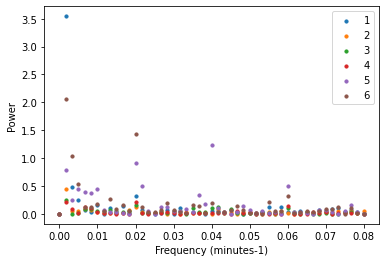

0.01

In [315]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


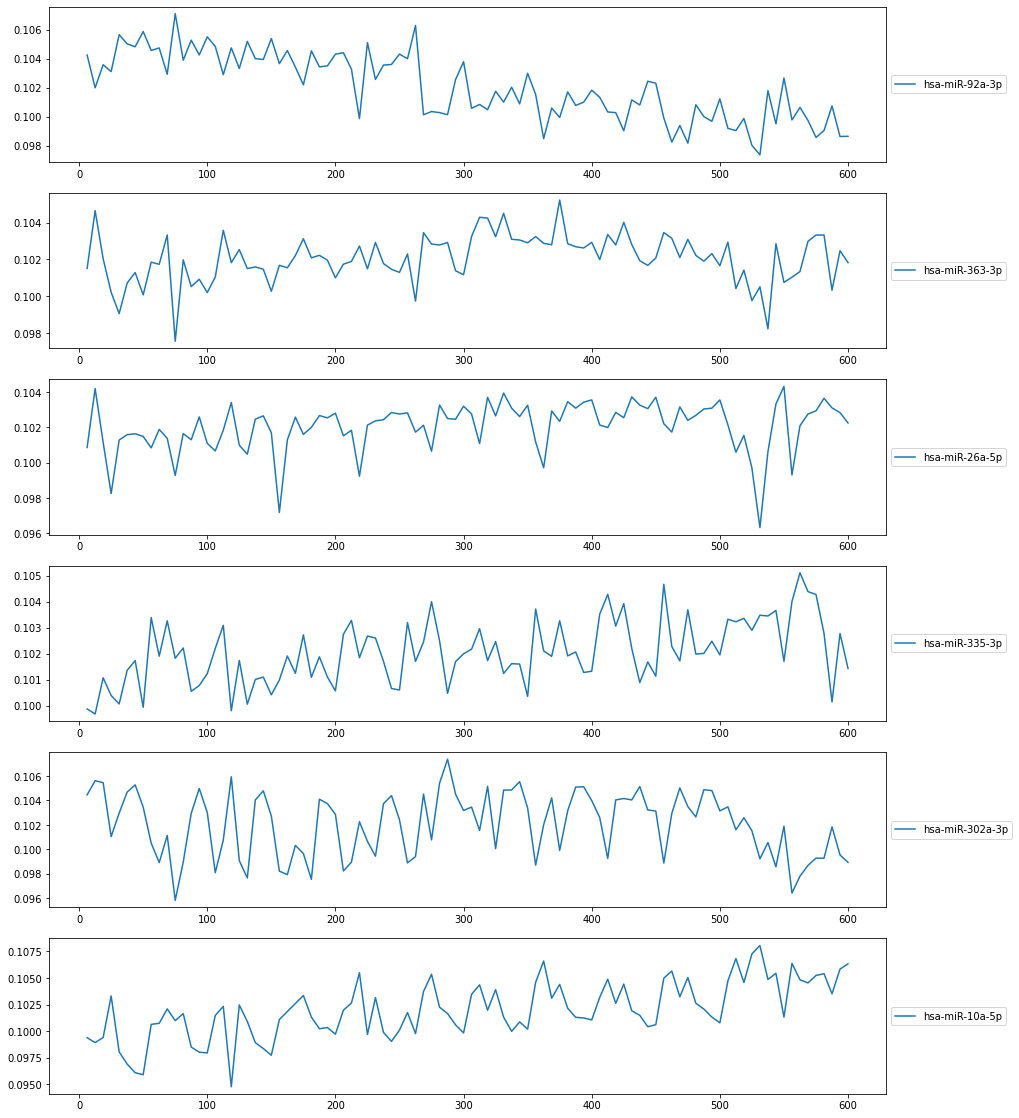

In [316]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s814_adata.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))